In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import keras
from keras.models import Sequential
from keras.layers import *
from keras_preprocessing.image import ImageDataGenerator

import zipfile 

import cv2
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model

In [3]:
data = pd.read_csv('../input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')
data.columns = ['emotion', 'Usage', 'pixels']

In [4]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

**Here we have *28709* Training dataset, *3589* Private Test and *3589* Public Test.**

In [6]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label



def plot_examples(label):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[label])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

        
        
def plot_all_emotions():
    N_train = train_labels.shape[0]

    sel = np.random.choice(range(N_train), replace=False, size=16)

    X_sel = train_images[sel, :, :, :]
    y_sel = train_labels[sel]

    plt.figure(figsize=[12,12])
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_sel[i,:,:,0], cmap='binary_r')
        plt.title(emotions[y_sel[i]])
        plt.axis('off')
    plt.show()
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    

    
def vis_training(hlist, start=1):
    
    loss = np.concatenate([h.history['loss'] for h in hlist])
    val_loss = np.concatenate([h.history['val_loss'] for h in hlist])
    acc = np.concatenate([h.history['accuracy'] for h in hlist])
    val_acc = np.concatenate([h.history['val_accuracy'] for h in hlist])
    
    epoch_range = range(1,len(loss)+1)

    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plt.plot(epoch_range[start-1:], loss[start-1:], label='Training Loss')
    plt.plot(epoch_range[start-1:], val_loss[start-1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epoch_range[start-1:], acc[start-1:], label='Training Accuracy')
    plt.plot(epoch_range[start-1:], val_acc[start-1:], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

In [7]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [8]:
full_train_images, full_train_labels = prepare_data(data[data['Usage']=='Training'])
test_images, test_labels = prepare_data(data[data['Usage']!='Training'])

print(full_train_images.shape)
print(full_train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(28709, 48, 48, 1)
(28709,)
(7178, 48, 48, 1)
(7178,)


In [9]:
train_images, valid_images, train_labels, valid_labels =\
    train_test_split(full_train_images, full_train_labels, test_size=0.2, random_state=1)

print(train_images.shape)
print(valid_images.shape)
print(train_labels.shape)
print(valid_labels.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)
(22967,)
(5742,)


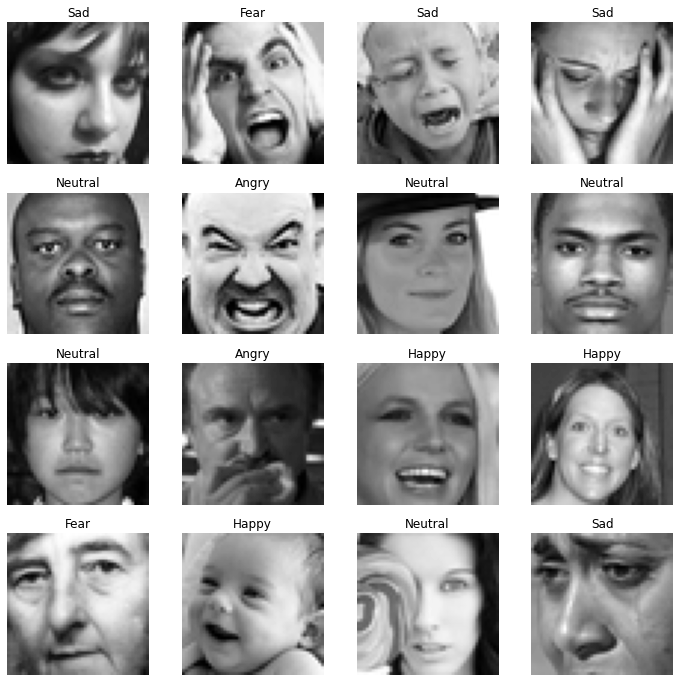

In [10]:
plot_all_emotions()

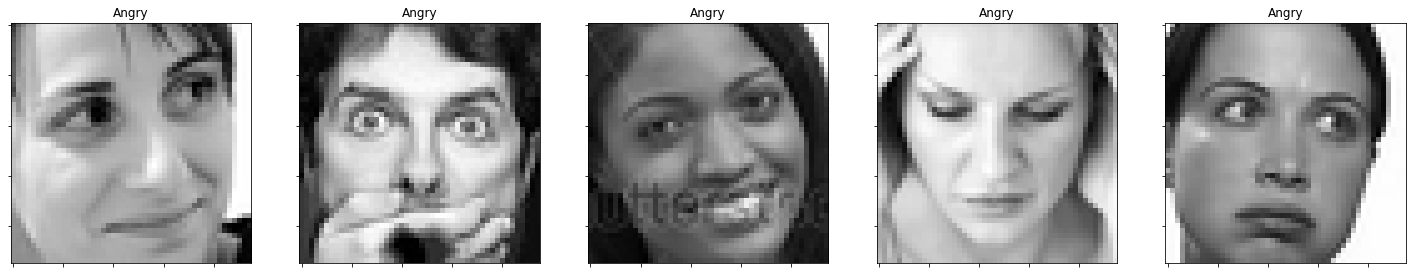

In [11]:
plot_examples(label=0)

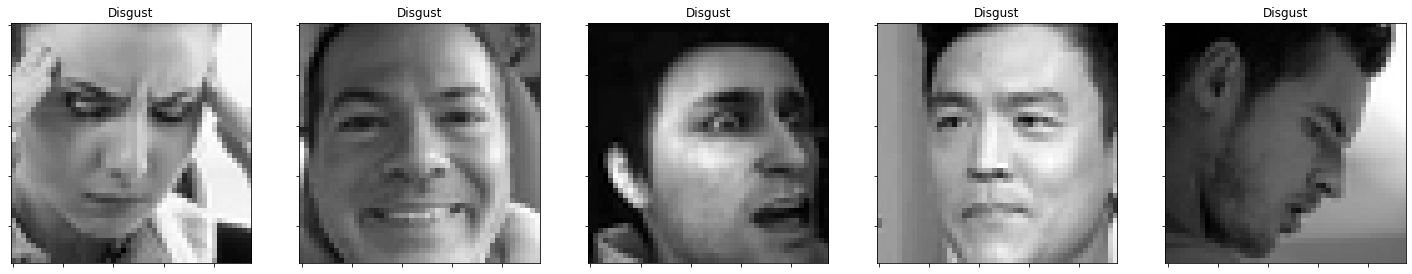

In [12]:
plot_examples(label=1)

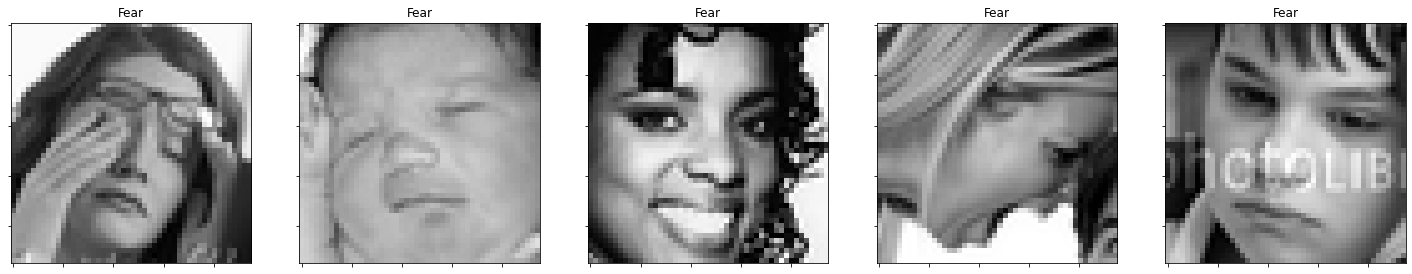

In [13]:
plot_examples(label=2)

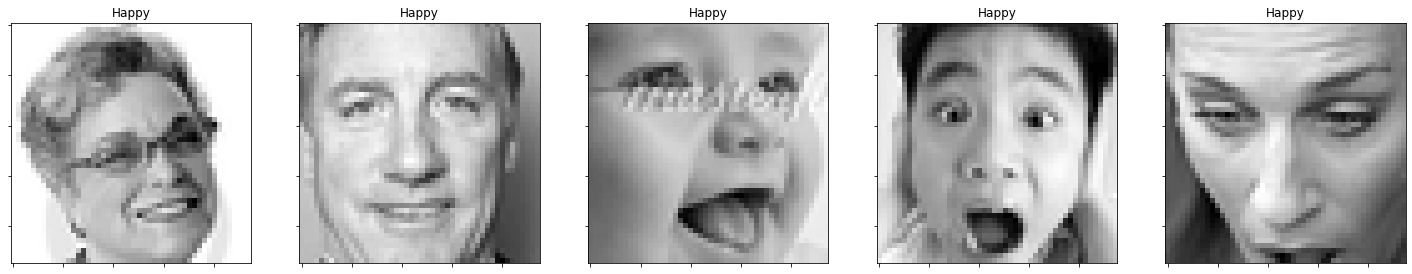

In [14]:
plot_examples(label=3)

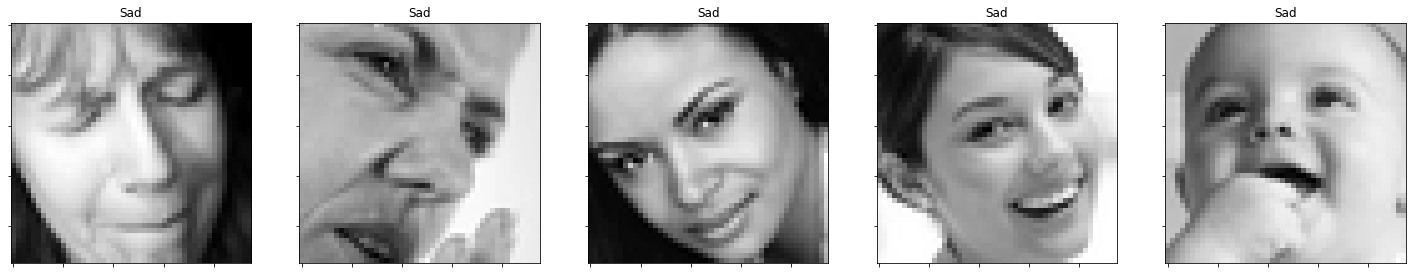

In [15]:
plot_examples(label=4)

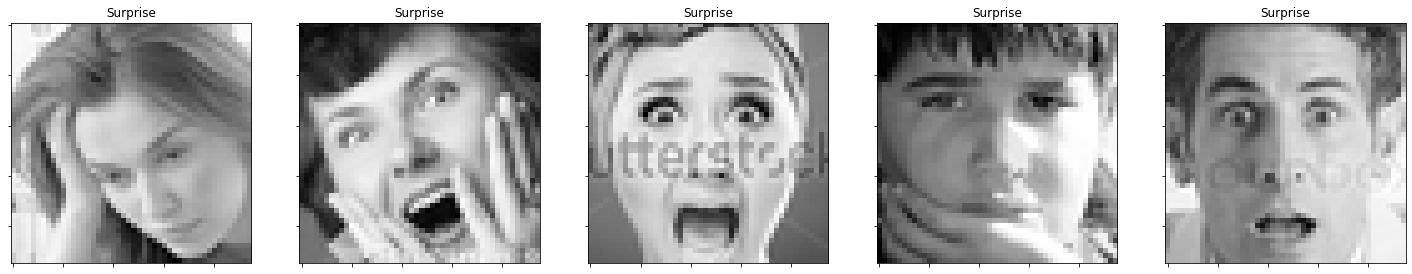

In [16]:
plot_examples(label=5)

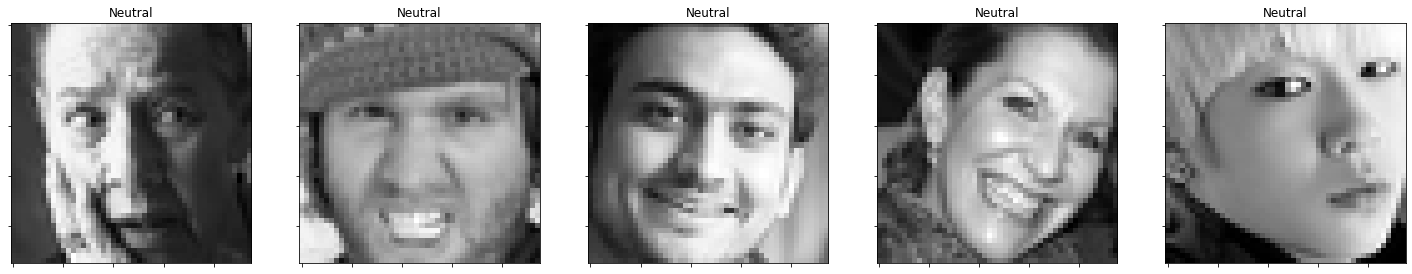

In [17]:
plot_examples(label=6)

In [18]:
class_weight = dict(zip(range(0, 7), (((data[data['Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data['Usage']=='Training']['emotion'])).tolist()))

In [19]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

## CNN Model

In [20]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
with tpu_strategy.scope():
    model = Sequential()

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(48,48,1)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(7, activation='softmax'))




    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=opt, metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       5

In [22]:
h1 = model.fit(train_images, train_labels, batch_size=256, epochs=30, verbose=1, validation_data=(valid_images, valid_labels))

Epoch 1/30
90/90 [==============================] - 26s 162ms/step - loss: 2.1226 - accuracy: 0.1994 - val_loss: 1.8622 - val_accuracy: 0.1594
Epoch 2/30
90/90 [==============================] - 3s 32ms/step - loss: 1.8266 - accuracy: 0.2374 - val_loss: 1.9851 - val_accuracy: 0.2564
Epoch 3/30
90/90 [==============================] - 3s 31ms/step - loss: 1.7862 - accuracy: 0.2639 - val_loss: 1.8866 - val_accuracy: 0.2611
Epoch 4/30
90/90 [==============================] - 3s 31ms/step - loss: 1.7003 - accuracy: 0.3158 - val_loss: 1.7265 - val_accuracy: 0.2886
Epoch 5/30
90/90 [==============================] - 3s 31ms/step - loss: 1.6163 - accuracy: 0.3557 - val_loss: 1.6971 - val_accuracy: 0.3339
Epoch 6/30
90/90 [==============================] - 3s 31ms/step - loss: 1.5180 - accuracy: 0.3976 - val_loss: 1.5051 - val_accuracy: 0.4383
Epoch 7/30
90/90 [==============================] - 3s 31ms/step - loss: 1.4436 - accuracy: 0.4322 - val_loss: 1.3941 - val_accuracy: 0.4690
Epoch 8/30


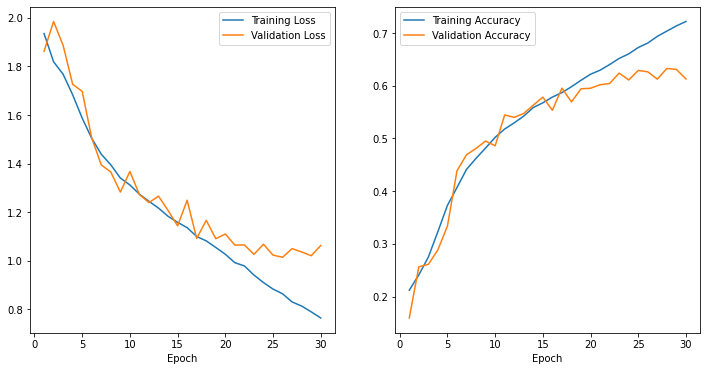

In [23]:
vis_training([h1])

In [24]:
keras.backend.set_value(model.optimizer.learning_rate, 0.00001)

h2 = model.fit(train_images, train_labels, batch_size=256, epochs=30, verbose=1, 
                   validation_data =(valid_images, valid_labels)) 

Epoch 1/30
90/90 [==============================] - 3s 34ms/step - loss: 0.7145 - accuracy: 0.7340 - val_loss: 0.9924 - val_accuracy: 0.6365
Epoch 2/30
90/90 [==============================] - 3s 31ms/step - loss: 0.6914 - accuracy: 0.7493 - val_loss: 0.9821 - val_accuracy: 0.6425
Epoch 3/30
90/90 [==============================] - 3s 31ms/step - loss: 0.6724 - accuracy: 0.7532 - val_loss: 0.9796 - val_accuracy: 0.6461
Epoch 4/30
90/90 [==============================] - 3s 32ms/step - loss: 0.6761 - accuracy: 0.7519 - val_loss: 0.9777 - val_accuracy: 0.6458
Epoch 5/30
90/90 [==============================] - 3s 31ms/step - loss: 0.6703 - accuracy: 0.7516 - val_loss: 0.9781 - val_accuracy: 0.6465
Epoch 6/30
90/90 [==============================] - 3s 32ms/step - loss: 0.6569 - accuracy: 0.7567 - val_loss: 0.9779 - val_accuracy: 0.6480
Epoch 7/30
90/90 [==============================] - 3s 32ms/step - loss: 0.6550 - accuracy: 0.7587 - val_loss: 0.9781 - val_accuracy: 0.6477
Epoch 8/30
90

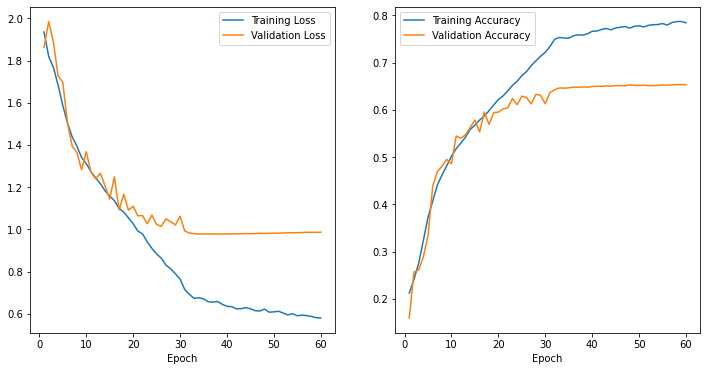

In [25]:
vis_training([h1, h2])

In [26]:
test_prob = model.predict(test_images)
test_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(test_pred == test_labels)

print(test_accuracy)

0.6514349400947339


In [27]:
conf_mat = confusion_matrix(test_labels, test_pred)

pd.DataFrame(conf_mat, columns=emotions.values(), index=emotions.values())

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral
Angry,544,10,87,41,151,18,107
Disgust,29,60,8,2,7,1,4
Fear,123,11,386,52,242,98,112
Happy,45,1,28,1530,49,33,88
Sad,122,8,105,65,688,16,243
Surprise,18,0,65,41,14,672,21
Neutral,72,5,45,98,197,20,796


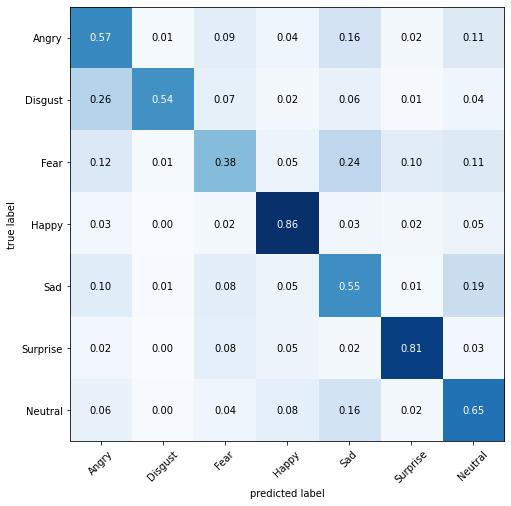

In [28]:
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

In [29]:
print(classification_report(test_labels, test_pred, target_names=emotions.values()))

              precision    recall  f1-score   support

       Angry       0.57      0.57      0.57       958
     Disgust       0.63      0.54      0.58       111
        Fear       0.53      0.38      0.44      1024
       Happy       0.84      0.86      0.85      1774
         Sad       0.51      0.55      0.53      1247
    Surprise       0.78      0.81      0.80       831
     Neutral       0.58      0.65      0.61      1233

    accuracy                           0.65      7178
   macro avg       0.64      0.62      0.63      7178
weighted avg       0.65      0.65      0.65      7178



In [30]:
model_json = model.to_json()
with open('model.json','w') as json_file:
    json_file.write(model_json)

In [31]:
model.save('final_model.h5')